In [174]:
from transformers.utils.hub import torch_cache_home

from custom_dataloading import load_encoded_dataset
from torch.utils.data import DataLoader
import torchvision
import wandb
import torch
from torch import nn, optim, utils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

In [16]:
from helpers import *
from vae_scott import ResNetVAE
from custom_dataloading import load_encoded_dataset

latent_dim = 7
latent_ch = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

vae = ResNetVAE(latent_dim=latent_dim, spatial=True).to(device)
vae.load_state_dict(torch.load(f'models/spatial_ae_{latent_dim}.pth', map_location=device))
vae.eval()


train_ds, test_ds = load_encoded_dataset(f'data/ResNetVAEEncoderSpatial_sp{latent_dim}/MNIST/')
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [17]:
class ResConvBlock(nn.Module):
    def __init__(self, ch, act=nn.SiLU, scale=0.1):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size=3, padding=1)
        self.act  = act()
        self.scale = scale
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return x + self.scale * self.act(self.conv(x))

In [8]:
# class ConvFlowModel(nn.Module):
#     def __init__(self, latent_dim, base_channels=32, n_layers=3, act=F.gelu):
#         super().__init__()
#         self.latent_dim = latent_dim
#         self.act = act
#
#         self.conv_in = nn.Conv2d(latent_dim + 1, base_channels, kernel_size=3, padding=1)
#
#         in_ch = base_channels
#         layers = []
#         for i in range(n_layers):
#             out_ch = base_channels * (2 ** i)
#             layers.append(ConvBlock(in_ch, out_ch, groups=groups, act=act))
#         self.layers = nn.ModuleList()
#         prev_ch = base_channels
#         for ch in channels:
#             self.layers.append(nn.Conv2d(prev_ch, ch, kernel_size=3, stride=1, padding=1))
#             self.layers.append(act)
#             prev_ch = ch
#         self.layers.append(nn.Conv2d(prev_ch, latent_dim, kernel_size=3))
#
#     def forward(self, x, t):
#         t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
#         x = torch.cat([x, t], dim=1)
#         x = act(self.fc_in(x))
#         x = act(self.fc2(x))
#         x = act(self.fc3(x))
#         return self.fc_out(x)

In [86]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, act=nn.SiLU):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.act = act()
        # nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')  # test later
        nn.init.zeros_(self.conv.bias)  # start zero?

    def forward(self, x):
        return self.act(self.conv(x))

class ConvFlowNet(nn.Module):
    def __init__(self, latent_ch, hidden=32, depth=3, grow=True):
        super().__init__()
        self.in_conv  = nn.Conv2d(latent_ch + 1, hidden, 3, padding=1)
        channels = [hidden * (2**i) for i in range(depth)] if grow else [hidden] * depth

        self.blocks = nn.Sequential(
            *[ConvBlock(in_ch, out_ch)
              for in_ch, out_ch in zip(channels[:-1], channels[1:])]
        )

        self.out_conv = nn.Conv2d(channels[-1], latent_ch, 3, padding=1)
        nn.init.zeros_(self.out_conv.weight)
        nn.init.zeros_(self.out_conv.bias)

    def forward(self, z, t):
        # z: [B,C,H,W], t: [B] or [B,1]
        B, C, H, W = z.shape
        t_img = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        h = F.silu(self.in_conv(torch.cat([z, t_img], dim=1)))
        h = self.blocks(h)
        return self.out_conv(h)

In [87]:
project = 'spatial_vae_conv_testing'
def train_flow_model(model, train_loader, test_loader, name='flow_model', pretrained_model=None, epochs=20, lr=0.001, warp_fn=None, new_points_every=1):
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    global_step = 1

    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, _) in enumerate(pbar):
            optimizer.zero_grad()

            # Get data and create a sample from it to calc movement
            target_x = data.to(device)
            sampled_x = torch.randn_like(target_x)
            B = sampled_x.size(0)

            if global_step % new_points_every == 0:
                if pretrained_model:   # ReFlow
                    target_x = integrate_path(pretrained_model, sampled_x, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)

            t  = torch.rand(B, 1, device=sampled_x.device, dtype=sampled_x.dtype)
            
            t4 = t.view(B, 1, 1, 1)
            if warp_fn: t = warp_fn(t)
                
            interpolated_x = sampled_x * (1 - t4) + target_x * t4
            line_directions = target_x - sampled_x

            drift = model(interpolated_x, t)
            loss = criterion(drift, line_directions)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()

            wandb.log({
                "step": global_step,
                "train_loss": loss.item(),
                "cos_sim": cos_sim.item(),
                "drift": drift.norm(dim=1).mean().item(),
            })
            global_step += 1

    return model

In [88]:
model = ConvFlowNet(latent_ch)
model.to(device)

ConvFlowNet(
  (in_conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
  )
  (out_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [92]:
train_flow_model(model, train_dl, test_dl, name=f'sp_flow_{latent_dim}_ogConv', epochs=20)

cos_sim,▁▃▄▃▂▂▄▅▅▄▅▄▄▄▅▅▃▆▇▅█▆▆▆▇▅▄▆▅▇▄▆▅▇▇▄▅▆▇▇
drift,▃▅▄▅▅▂▄▄▇▁▄▅▆▇▆▅▄▅▃▆█▇▇▇▆▇▇▅▇▅█▅▇▆▇▆▇▆▆▃
step,▁▁▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_loss,█▆▅▅▆▄▅▇▅▆▇▅▅▅▅█▃▃▅▄▆▄▃▅▁▄▄▅▅▄▆▅▂▅▃▂▂▂▄▁
cos_sim,0.63308
drift,1.24535
step,2345
train_loss,1.16027


Epoch 20/20: 100%|██████████| 469/469 [00:01<00:00, 243.22it/s]


ConvFlowNet(
  (in_conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
  )
  (out_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [98]:
new_model = ConvFlowNet(latent_ch)
new_model.to(device)
train_flow_model(new_model, train_dl, test_dl, name=f'sp_reflow_{latent_dim}',pretrained_model=model, epochs=20)

cos_sim,▁▆▆▆▆▆▆▇▇▆▆█▇▇▇▇█▇██▇█▇█▇▇▇▇▇▇▇▆▆▇▇▇▇▇▇▇
drift,▁▄▃▆▇▄▇▆▅▇▄▅▆▆▆▅▆█▅▇▇▆▇▆▇▅▇█▇▄▇▅▇▇▆▅▆▇▇▇
step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
train_loss,██▅▅▄▃▃▃▄▂▃▃▄▃▃▃▃▂▃▃▃▃▂▃▃▂▁▂▃▃▂▃▂▂▂▁▂▂▂▁
cos_sim,0.6233
drift,1.22916
step,9380
train_loss,1.23371


Epoch 20/20: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


ConvFlowNet(
  (in_conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
  )
  (out_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [157]:
from safetensors.torch import save_file
# save_file(model.state_dict(), 'models/safetensors/flow/sp_flow_7x7.safetensors')
# save_file(new_model.state_dict(), 'models/safetensors/flow/sp_reflow_7x7.safetensors')
state_dict_vae = torch.load(f'models/spatial_ae_{latent_dim}.pth')
save_file(state_dict_vae, 'models/safetensors/vae/sp_vae.safetensors')


# torch.save(model.state_dict(), 'models/sp_flow_7x7.pth')
# torch.save(new_model.state_dict(), 'models/sp_flow_7x7.pth')

In [189]:
class MarcosModel(nn.Module):
    def __init__(self, vae, flow_model, latent_dim=3):
        super().__init__()

        #--- REQUIRED INFO:
        self.info = {
            'team': 'Marco',  # REPLACE with your team name. This will be public
            'names': 'Marco', # or single name. This will be kept private
        }
        self.latent_dim = latent_dim
        self.latent_shape = (1,latent_dim,latent_dim)
        self.device = 'mps'

        #--- TEMP
        self.vae = vae
        self.flow_model = flow_model

    def generate_samples(self, n_samples:int, n_steps=100) -> torch.Tensor:
        self.flow_model.eval(); self.vae.eval()
        z0 = torch.randn(n_samples, *self.latent_shape, device=self.device)
        z1 = integrate_path(self.flow_model, z0, n_steps=n_steps, step_fn=rk4_step, latent_2d=True)
        return F.sigmoid(self.decode(z1)).squeeze(1)
        # return F.sigmoid(self.decode(z1)).view(-1, 28, 28)

    def encode(self, images: torch.Tensor) -> torch.Tensor:
        # if your vae has linear layers, flatten first
        # if your vae has conv layers, comment out next line
        # images = images.view(images.size(0), -1)
        with torch.no_grad():
            z = self.vae.encoder(images.to(self.device))
            mu = z[:, :self.latent_dim]  # return only first half (mu)
            return mu

    def decode(self, latents: torch.Tensor) -> torch.Tensor:
        return self.vae.decoder(latents)

    def to(self, device):
        self.device = device
        self.vae.to(self.device)
        self.flow_model.to(self.device)
        return self

In [190]:
@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100, save_trajectories=False, warp_fn=None, latent_2d=False):
    p = next(model.parameters())
    device, model_dtype = p.device, p.dtype

    current_points = initial_points.to(device=device, dtype=model_dtype).clone()
    model.eval()

    ts = torch.linspace(0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn: ts = warp_fn(ts)
    if latent_2d: t_batch = torch.empty((current_points.shape[0], 1), device=device, dtype=model_dtype)

    for i in range(len(ts) - 1):
        t, dt = ts[i], ts[i + 1] - ts[i]
        if latent_2d: t = t_batch.fill_(t.item())

        current_points = step_fn(model, current_points, t, dt)

    return current_points

In [191]:
import matplotlib.pyplot as plt

def plot_generated(gen_xhat, nrow=5):
    gen_xhat = gen_xhat.detach().cpu()

    # assume shape (N, 28, 28)
    n_samples = gen_xhat.size(0)
    ncol = nrow
    nrow = (n_samples + ncol - 1) // ncol

    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*2, nrow*2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_samples:
            ax.imshow(gen_xhat[i], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [207]:
from helpers import BasicModel, plot_generated
flow_temp_class = BasicModel(vae, model, latent_shape=(1,7,7))

In [192]:
flow_class = MarcosModel(vae, model, latent_dim=latent_dim)
reflow_class = MarcosModel(vae, new_model, latent_dim=latent_dim)

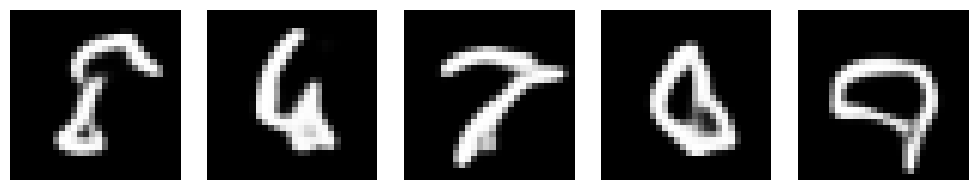

In [194]:
plot_generated(flow_class.generate_samples(5,5))

In [184]:
def comparative_generate_samples(flow1, flow2, vae, n_samples:int, n_steps=100) -> torch.Tensor:
    flow1.eval(); flow2.eval(); vae.eval()
    z0 = torch.randn(n_samples, 1, latent_dim, latent_dim, device=device)
    
    z1 = integrate_path(flow1, z0.clone(), n_steps=n_steps, step_fn=rk4_step, latent_2d=True)
    z2 = integrate_path(flow2, z0.clone(), n_steps=n_steps, step_fn=rk4_step, latent_2d=True)
    
    x1 = torch.sigmoid(vae.decoder(z1)).view(-1, 28, 28)
    x2 = torch.sigmoid(vae.decoder(z2)).view(-1, 28, 28)
    return x1, x2

Normal Flow


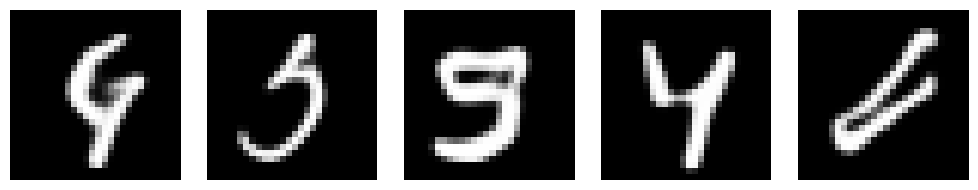

Re Flow


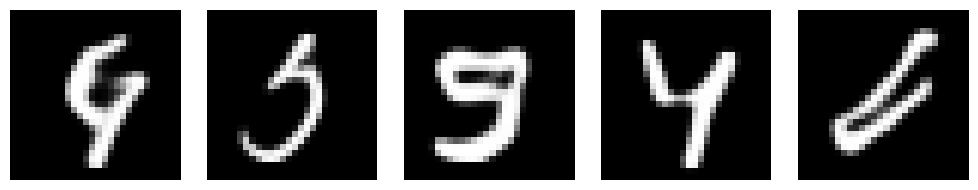

In [188]:
x1, x2 = comparative_generate_samples(model, new_model, vae, 5, 10)
print("Normal Flow")
plot_generated(x1)
print("Re Flow")
plot_generated(x2)

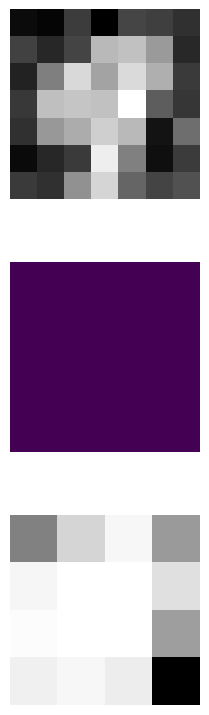

In [186]:
from vae_scott import test_inference_spatial
test_inference_spatial(vae, train_ds)

In [169]:
test_inference

<function vae_scott.test_inference(model, test_ds, idx=None, return_fig=False)>